In [1]:

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np
from sklearn.utils import resample
import random
# Import necessary libraries
from keras.datasets import cifar10

In [2]:
import datetime
from datetime import datetime

config = {
    'currentModel' : 'ENSEMBLE',
    'training' : True,
    'overFit' : False,
    'heldOutClasses' : False,
    'epochs' : 1,
    'patience' : 1,
    'saveModel' : True,
    'seed': 0,
}

config['ensembleSize'] = 1 if 'ENSEMBLE' in config['currentModel'] else 1
config['startEpochs'] = 1 if 'overFit' in config['currentModel'] else 1

# Formatted as 'YYYY-MM-DD'
today = datetime.today().strftime('%Y-%m-%d')

# Get file representation of the config folder 
file_str = f'/{today}/'

for key, value in config.items():
    file_str += f'{key}-{value}_' 


MODEL_FILE = f'./models/' + file_str

np.random.seed(config['seed'])
# set random seed for tf
tf.random.set_seed(config['seed'])
# random seed for python built-in random module
random.seed(config['seed'])

In [3]:
from sklearn.model_selection import train_test_split

dataset = cifar10.load_data()

# Turn it into a binary classification problem by making it frogs or not frogs
(train_images, train_labels), (test_images, test_labels) = dataset

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Separate frog and not frog images
frog_indices = np.where(train_labels == 6)[0]
not_frog_indices = np.where(train_labels != 6)[0]

if config['heldOutClasses']:
    config['heldOutClasses'] = [0, 1]
else:
    config['heldOutClasses'] = []

held_out_class_indices_train = np.where(np.isin(train_labels, config['heldOutClasses']))[0]    
held_out_class_indices_test = np.where(np.isin(test_labels, config['heldOutClasses']))[0]    

not_frog_indices = np.setdiff1d(not_frog_indices, held_out_class_indices_train)

# Downsample majority (not frog)
not_frog_downsampled = resample(not_frog_indices,
                                replace=False, # sample without replacement
                                n_samples=len(frog_indices), # match minority n
                                random_state=27) # reproducible results

# Combine minority and downsampled majority
downsampled_indices = np.concatenate([frog_indices, not_frog_downsampled])

# Downsampled feature and label sets
train_labels = np.where(train_labels == 6, 1, 0)
test_labels = np.where(test_labels == 6, 1, 0)

train_images = train_images[downsampled_indices]
train_labels = train_labels[downsampled_indices]

test_images_held_out = test_images[held_out_class_indices_test]
test_labels_held_out = test_labels[held_out_class_indices_test]

test_images = np.delete(test_images, held_out_class_indices_test, axis=0)
test_labels = np.delete(test_labels, held_out_class_indices_test, axis=0)


# Split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=config['seed'])




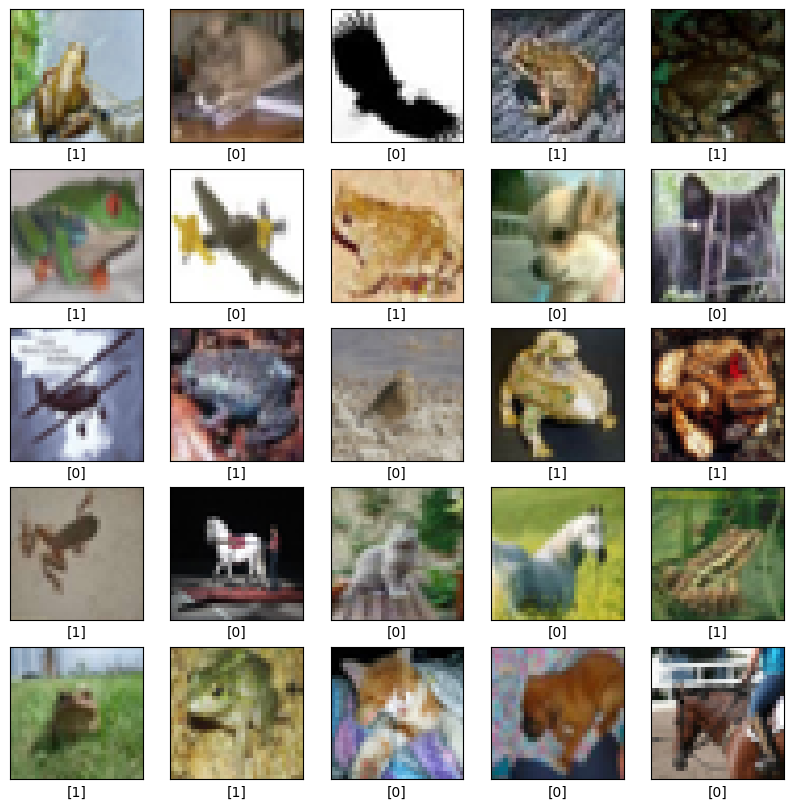

In [4]:
class_names = ['not_frog', 'frog']

randomly_chosen_indexes = np.random.uniform(0, len(train_images), 25).astype(int)
plt.figure(figsize=(10,10))
for i, value in enumerate(randomly_chosen_indexes):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[value])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(train_labels[value])
plt.show()

### Compile and train the model

In [5]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint



history_list = {}

history_dict_base = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

history_dict = {}


for i in range(config['ensembleSize']): 
    history_dict[i] = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
    }

    history_list[i] = []

print(history_dict)



{0: {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}}


In [6]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model

# Function to set dropout rate
def set_dropout_rate(model, new_rate):
    for layer in model.layers:
        if isinstance(layer, Dropout):
            layer.rate = new_rate


def create_dropout_model(dropout_rate=0.5):
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model
  

In [7]:
 
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Model

def create_model():
    # Input layer
    inputs = Input(shape=(32, 32, 3))

    # Convolutional and MaxPooling layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layers with dropout
    x = Dense(64, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [19]:
from tensorflow.keras.callbacks import TensorBoard

for i in range(config['ensembleSize']):


    log_dir = f"./tenserboard/{MODEL_FILE}/{i}"
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_auc', patience=config['patience'], start_from_epoch=config['startEpochs'], restore_best_weights=True, mode='max')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(f'{MODEL_FILE}/{i}.keras', monitor='val_auc', save_best_only=True)

    callbacks = [early_stopping,tensorboard_callback]

    if config['saveModel']:
        callbacks.append(model_checkpoint)


    model = create_dropout_model() if config['currentModel'] == 'BNN' else create_model()
    
    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc', curve='ROC')])

    set_dropout_rate(model, np.nextafter(np.float32(0), np.float32(1))) if config['currentModel'] == 'BNN' else ''

    X_train_subset, y_train_subset = resample(train_images, train_labels)

    history = model.fit(X_train_subset, y_train_subset, epochs=config['epochs'],
                        validation_data=(val_images, val_labels),
                        callbacks=callbacks)

    set_dropout_rate(model, 0.5) if config['currentModel'] == 'BNN' else ''

    history_list[i].append(history)

    for history in history_list[i]:
        for key in history_dict_base.keys():
            history_dict[i][key].extend(history.history[key])


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6859 - auc: 0.7585 - loss: 0.5757 - val_accuracy: 0.7700 - val_auc: 0.8798 - val_loss: 0.4904


In [9]:
if config['currentModel'] == 'BNN':
    import numpy as np
    from tensorflow.keras.models import load_model

    class MCDropoutModel:
        def __init__(self, base_model, num_predictions=100, dropout_rate=0.5):
            self.base_model = base_model
            self.num_predictions = num_predictions
            self.dropout_rate = dropout_rate

        def verbose_predict(self, inputs):
            outputs = []
            set_dropout_rate(self.base_model, self.dropout_rate)
            for _ in range(self.num_predictions):
                # Enable dropout during prediction
                outputs.append(self.base_model(inputs, training=True))

            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack

    loaded_model = load_model(f'{MODEL_FILE}/0.keras')

    # Wrap the base model with the MCDropoutModel
    model_under_test = MCDropoutModel(loaded_model, num_predictions=20)

In [10]:

# set_dropout_rate(loaded_model, 0.5)
# model_with_two_predictions = MCDropoutModel(loaded_model, num_predictions=2)

# predictions = model_with_two_predictions.verbose_predict(test_images[:4])

In [11]:
if config['currentModel'] == 'ENSEMBLE':
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Average
    from tensorflow.keras.models import load_model


    class EnsembleModel(tf.keras.Model):
        def __init__(self, models, **kwargs):
            super(EnsembleModel, self).__init__(**kwargs)
            self.models = models

        def call(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Average the outputs of each model
            # First, stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            # Then, calculate the mean along the first axis
            outputs_mean = tf.reduce_mean(outputs_stack, axis=0)

            return outputs_mean
        
        def verbose_predict(self, inputs):
            # Forward pass through each model
            outputs = [model(inputs) for model in self.models]

            # Stack all model outputs
            outputs_stack = tf.stack(outputs, axis=0)

            return outputs_stack


    model_list = []

    for i in range(config['ensembleSize']): 
        ensemble_member = load_model(f'{MODEL_FILE}/{i}.keras')
        ensemble_member.evaluate(test_images, test_labels)
        model_list.append(ensemble_member)


    # Create the ensemble model
    model_under_test = EnsembleModel(model_list)

    # Compile the ensemble model
    model_under_test.compile(optimizer='adam',
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

    # model_under_test(test_images)

    # Evaluate the ensemble model
    performance = model_under_test.evaluate(test_images, test_labels)
    print(performance)
    # print('Ensemble accuracy:', accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6520 - auc: 0.9129 - loss: 0.6703
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6520 - auc: 0.0000e+00 - loss: 0.0000e+00
[0.0, 0.0, 0.6480000019073486, 0.0, 0.6480000019073486]


313/313 - 3s - 9ms/step - accuracy: 0.6480 - auc: 0.9073 - loss: 0.6795


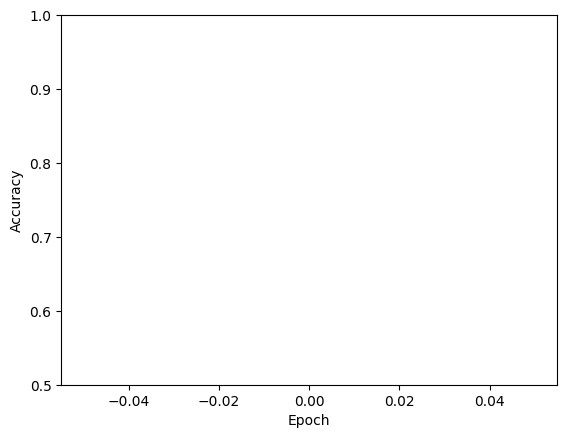

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(config['ensembleSize']):
    model = load_model(f'{MODEL_FILE}/{i}.keras')
    plt.plot(history_dict[i]['accuracy'], label=f'accuracy {i}')
    plt.plot(history_dict[i]['val_accuracy'], label = f'val_accuracy {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])

    test_loss, test_acc, test_auc = model.evaluate(test_images,  test_labels, verbose=2)

In [13]:
import pandas as pd

def produce_df_from_predictions(model_under_test, test_images, test_labels):
    outputs_stack = model_under_test.verbose_predict(test_images)
    outputs_mean = np.mean(outputs_stack, axis=0)
    outputs_variance = np.var(outputs_stack, axis=0)
    ensemble_predictions = np.where(outputs_mean > 0.5, 1, 0)
    individual_outputs = np.array(outputs_stack).squeeze().T.tolist()
    output_confidence = np.abs(outputs_mean - 0.5)
    prediction_outcome = np.where(ensemble_predictions != test_labels, 0, 1)
    np_df = np.hstack((output_confidence, outputs_variance, prediction_outcome, outputs_mean, test_labels, ensemble_predictions))
    df = pd.DataFrame(np_df, columns=['confidence', 'variance', 'outcome', 'mean', 'label', 'prediction'])
    df['individual_predictions'] = individual_outputs
    print(df.head())
    df['tp'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 1), axis=1)
    df['fp'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 1), axis=1)
    df['tn'] = df.apply(lambda row: int(row['label'] == 0 and row['prediction'] == 0), axis=1)
    df['fn'] = df.apply(lambda row: int(row['label'] == 1 and row['prediction'] == 0), axis=1)

    df.head()

    return df

df = produce_df_from_predictions(model_under_test, test_images, test_labels)

df_held_out = produce_df_from_predictions(model_under_test, test_images_held_out, test_labels_held_out)
print(df_held_out.head())


   confidence  variance  outcome      mean  label  prediction  \
0    0.401672       0.0      0.0  0.901672    0.0         1.0   
1    0.476926       0.0      1.0  0.023074    0.0         0.0   
2    0.477786       0.0      1.0  0.022214    0.0         0.0   
3    0.439757       0.0      1.0  0.060243    0.0         0.0   
4    0.395318       0.0      1.0  0.895318    1.0         1.0   

   individual_predictions  
0                0.901672  
1                0.023074  
2                0.022214  
3                0.060243  
4                0.895318  
Empty DataFrame
Columns: [confidence, variance, outcome, mean, label, prediction, individual_predictions]
Index: []
Empty DataFrame
Columns: [confidence, variance, outcome, mean, label, prediction, individual_predictions, tp, fp, tn, fn]
Index: []


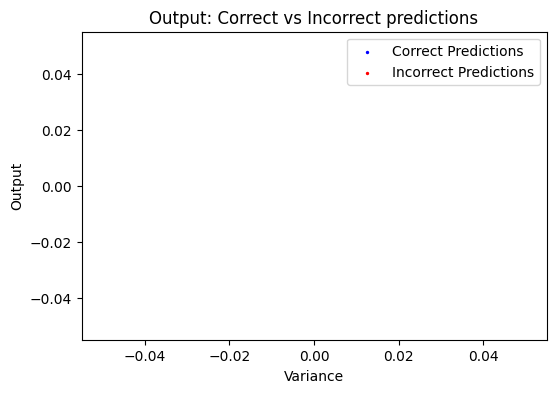

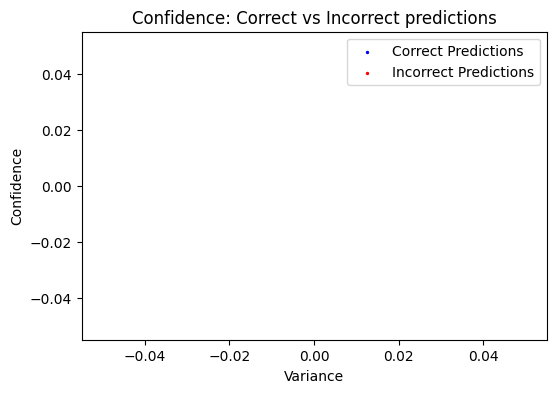

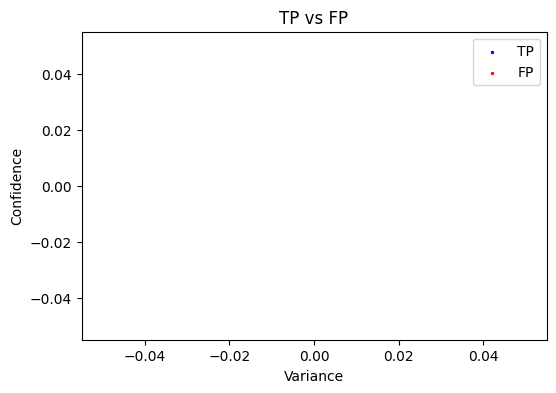

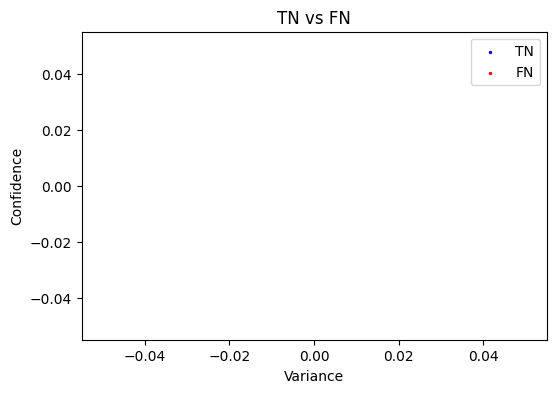

In [14]:

def normalize_and_plot(x, y, color, label=None):
    """Normalize and plot the given data."""
    # Convert to numpy for plotting

    # Normalize x and y
    # x_numpy_normalized = (x - x.min()) / (x.max() - x.min())
    # y_numpy_normalized = (y - y.min()) / (y.max() - y.min())

    # Plotting
    plt.scatter(x, y, color=color, label=label, s=2)

print()

def plot_confidence_vs_variance_findings(dataframes):
    for df in dataframes:
        var_correct = df[df['outcome'] == 1]['variance'].to_numpy()
        var_incorrect = df[df['outcome'] == 0]['variance'].to_numpy()
        output_correct = df[df['outcome'] == 1]['mean'].to_numpy()
        output_incorrect = df[df['outcome'] == 0]['mean'].to_numpy()
        conf_correct = df[df['outcome'] == 1]['confidence'].to_numpy()
        conf_incorrect = df[df['outcome'] == 0]['confidence'].to_numpy()
        var_tp = df[df['tp'] == 1]['variance'].to_numpy()
        conf_tp = df[df['tp'] == 1]['confidence'].to_numpy()
        var_fp = df[df['fp'] == 1]['variance'].to_numpy()
        conf_fp = df[df['fp'] == 1]['confidence'].to_numpy()
        var_tn = df[df['tn'] == 1]['variance'].to_numpy()
        conf_tn = df[df['tn'] == 1]['confidence'].to_numpy()
        var_fn = df[df['fn'] == 1]['variance'].to_numpy()
        conf_fn = df[df['fn'] == 1]['confidence'].to_numpy()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_correct, output_correct, 'blue', 'Correct Predictions')
        normalize_and_plot(var_incorrect, output_incorrect, 'red', 'Incorrect Predictions')
        # Add labels and legend
        plt.title(f'Output: Correct vs Incorrect predictions')
        plt.xlabel('Variance')
        plt.ylabel('Output')
        plt.legend()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_correct, conf_correct, 'blue', 'Correct Predictions')
        normalize_and_plot(var_incorrect, conf_incorrect, 'red', 'Incorrect Predictions')
        # Add labels and legend
        plt.title(f'Confidence: Correct vs Incorrect predictions')
        plt.xlabel('Variance')
        plt.ylabel('Confidence')
        plt.legend()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_tp, conf_tp, 'blue', 'TP')
        normalize_and_plot(var_fp, conf_fp, 'red', 'FP')
        plt.title(f'TP vs FP')
        plt.xlabel('Variance')
        plt.ylabel('Confidence')
        plt.legend()

        plt.figure(figsize=(6,4))
        normalize_and_plot(var_tn, conf_tn, 'blue', 'TN')
        normalize_and_plot(var_fn, conf_fn, 'red', 'FN')
        plt.title(f'TN vs FN')
        plt.xlabel('Variance')
        plt.ylabel('Confidence')
        plt.legend()

plot_confidence_vs_variance_findings([df_held_out])

# Display the plot
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

tp_count = df['tp'].sum()
tn_count = df['tn'].sum()
fp_count = df['fp'].sum()
fn_count = df['fn'].sum()


accuracy = ( tp_count + tn_count ) / ( tp_count + tn_count + fp_count + fn_count )

precision = tp_count / ( tp_count + fp_count )

recall = tp_count / ( tp_count + fn_count )

f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )

confusion = confusion_matrix(test_labels, df['prediction'])

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.648
Precision: 0.2165991902834008
Recall: 0.963
F1 Score: 0.353654058024238
Confusion Matrix:
[[5517 3483]
 [  37  963]]


In [16]:

true_positive_indices = df[df['tp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_positive_indices = df[df['fp'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
true_negative_indices = df[df['tn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()
false_negative_indices = df[df['fn'] == 1].sort_values('confidence', ascending=False).index.to_numpy()

most_confident_outputs = false_negative_indices[0:24]

print(most_confident_outputs)




[3615 5607 4744 3693 7117 9501 8604 4304 9294  459 9641  820 2599  762
 2848  893 3030 1094 6917 2251 2671 9691 6656 5370]


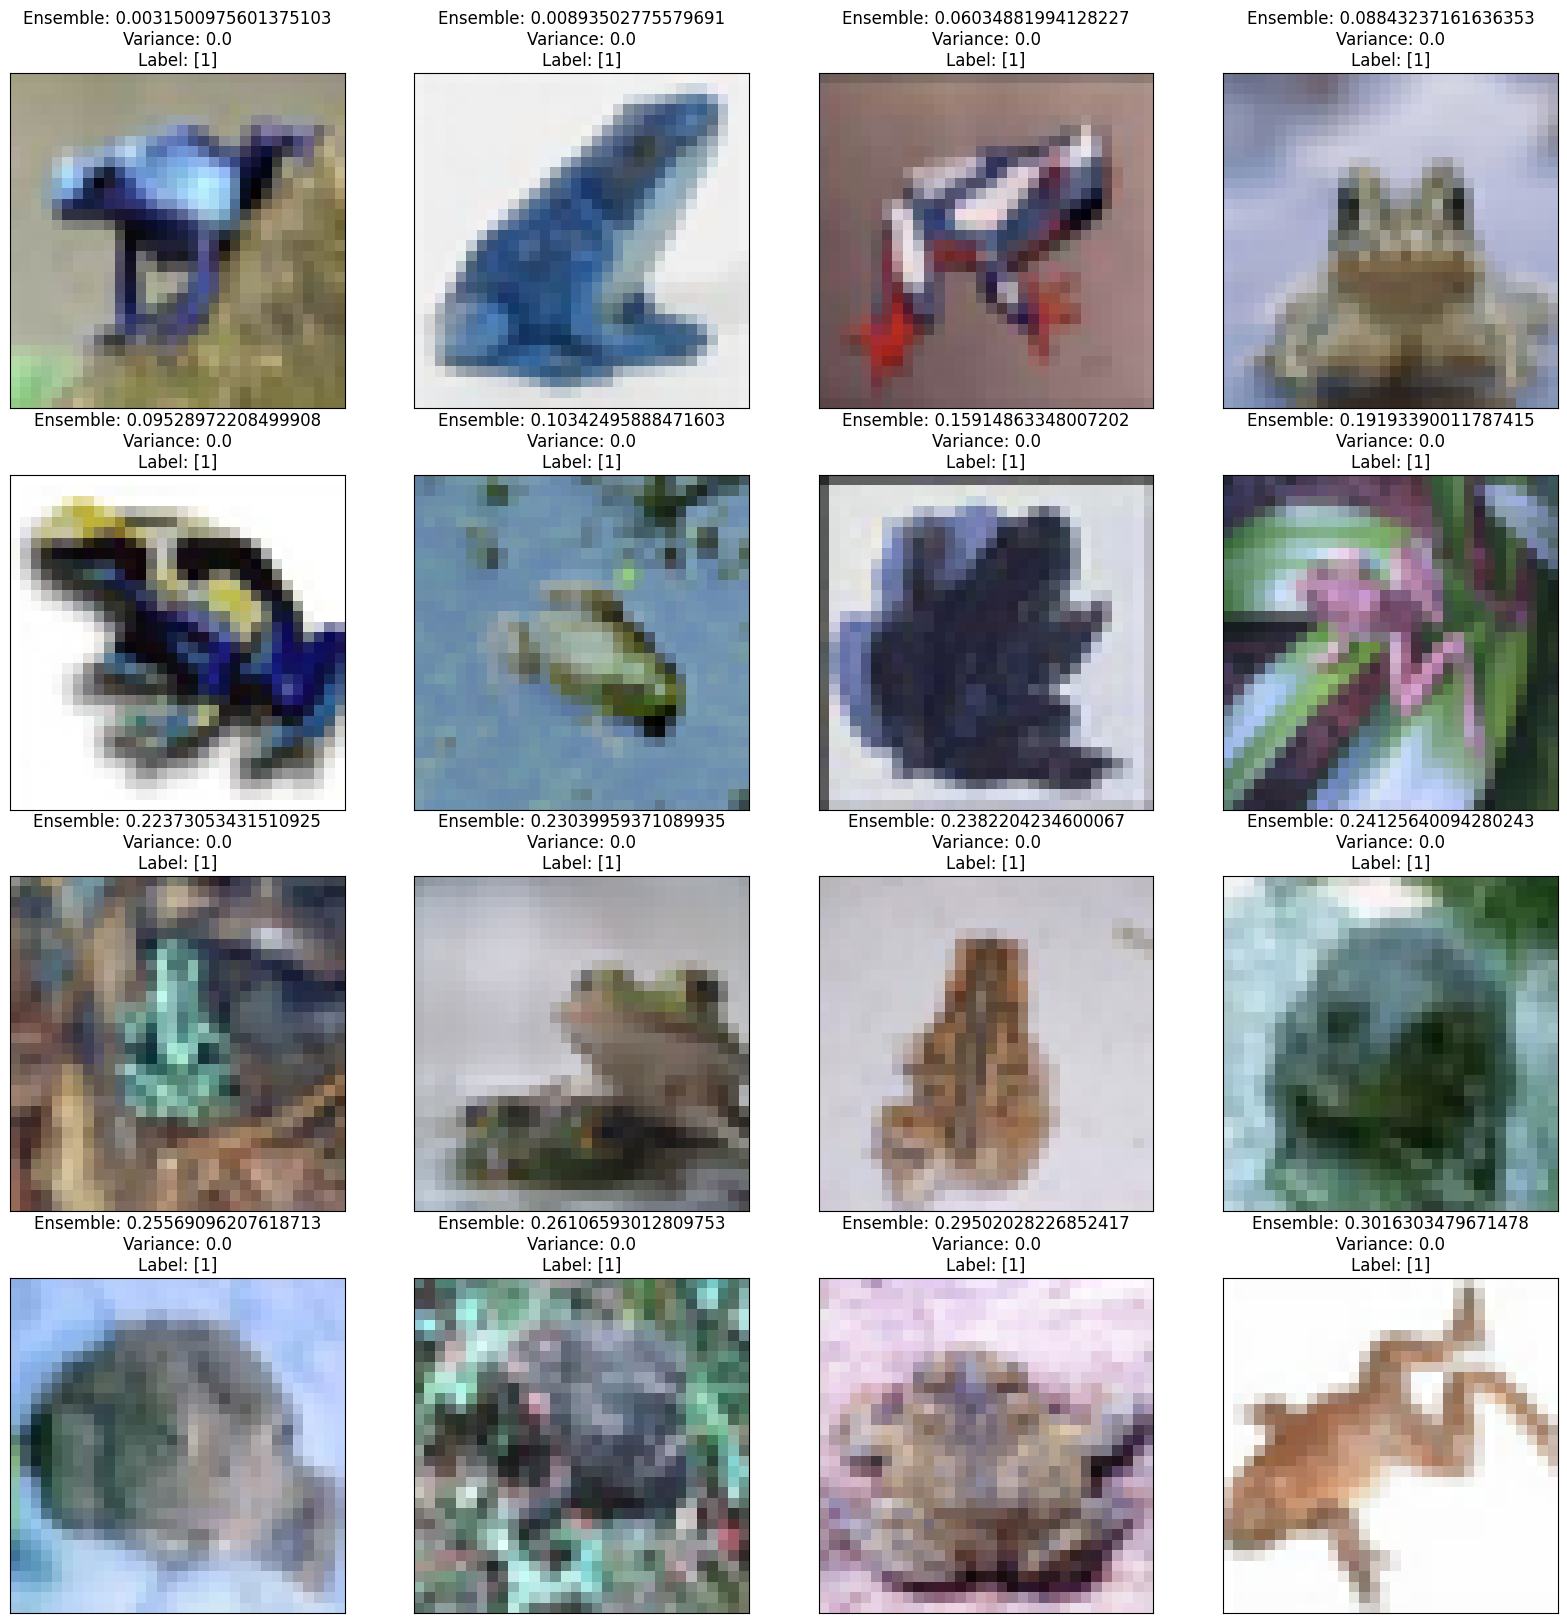

In [17]:



import matplotlib.pyplot as plt

# Create a 10x10 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    # Get the index of the current image
    index = most_confident_outputs[i]

    # Display the image
    ax.imshow(test_images[index], cmap='gray')

    # Get the predictions of the individual models and the ensemble
    # 2 x 10000 x 1
    individual_pred = df['individual_predictions'].iloc[index]
    ensemble_pred = df['mean'].iloc[index]
    ensemble_var = df['variance'].iloc[index]

    # Display the predictions
    ax.set_title(f'Ensemble: {ensemble_pred}\nVariance: {ensemble_var}\nLabel: {test_labels[index]}')

    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Display the figure
plt.show()

